In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# Import file
df_for_regression = pd.read_csv('data/data_for_regression.csv', index_col='Municipality Name')

In [38]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE

Approach:

NEW ANALYTICS: 
* score of the TRAIN and test set
* plot all the residuals between y_test and y_preds, not just looking at the averages in MAE and RMSE
* Test all models with cv

NEW MODELS:
* Repeat ever model with outliers removed
* Try a large test split
* Emphasis on all models with bootstraping 
* Jeff kept suggest gradboost even though that one sucked
* NN

In [4]:
# Raw Data

X0 = df_for_regression.drop(columns=['%recycle/hh'])
y0 = df_for_regression['%recycle/hh']

In [5]:
# Data w/o outliers
df_for_regression1 = df_for_regression[df_for_regression['%recycle/hh'] < 0.5]
X1 = df_for_regression1.drop(columns=['%recycle/hh'])
y1 = df_for_regression1['%recycle/hh']

**First** just going to look at fast models, (no grad boost) and just the raw data. I found [this nifty way of seeing the test train splits in the KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

In [6]:
cv_results = {}
cv_kf = KFold(n_splits=5, shuffle=True, random_state=8)

cv_set = 0
for train_index, test_index in cv_kf.split(X0):
    print("CV_KF set: ", cv_set)
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    cv_set = cv_set + 1

CV_KF set:  0
TRAIN: [  0   1   2   5   6   7   8   9  10  11  12  14  15  16  17  18  19  20
  21  24  27  28  29  31  32  33  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  54  55  57  58  59  60  61  63  64  65  66
  67  68  69  70  72  73  74  75  76  81  83  84  85  86  88  89  90  91
  92  95  96  97  98  99 101 102 104 105 106 107 108 109 112 115 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 142 143 144 145 146 147 149 150 151 152 153 154 155 156
 157 159 160 161 162 164 166 167 168 169 170 171 172 173 174 175 176 179
 181 183 184 186 188 189 190 191 194 195 196 197 199 200 201 202 203 205
 206 207 208 210 211 213 214 215 216 217 218 220 223 224 225 226 227 228
 229 231 234 235 236 237 238 239 240 241 242 243 245 246 247 248 249 250
 251 252 253 254 255 257 258 259 261 262 263 264 265 266 267 268 269 270]
TEST: [  3   4  13  22  23  25  26  30  34  52  53  56  62  71  77  78  79  80
  82  87  93  94 100 10

In [7]:
cv = cross_val_score(DummyRegressor(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_dummy'] = np.append(cv,cv_mean)
cv

array([-0.00262471, -0.01296429, -0.03149499, -0.03040279, -0.074853  ])

In [8]:
cv = cross_val_score(LinearRegression(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_lr'] = np.append(cv,cv_mean)
cv

array([-0.08579309, -0.42197651,  0.12508735, -0.01904092, -0.46782195])

In [9]:
cv = cross_val_score(Ridge(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_ridge'] = np.append(cv,cv_mean)
cv

array([-0.02700948, -0.38914783,  0.13313634,  0.00084912, -0.44299328])

In [10]:
cv = cross_val_score(Lasso(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_lasso'] = np.append(cv,cv_mean)
cv

array([ 0.02981099,  0.02036987, -0.01632682, -0.04080895, -0.30929207])

In [11]:
cv = cross_val_score(RandomForestRegressor(random_state=8), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_RF'] = np.append(cv,cv_mean)
cv

array([ 0.03086535,  0.19833803,  0.11729076, -0.17294445,  0.21163409])

In [12]:
cv = cross_val_score(BaggingRegressor(random_state=8), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_bagging'] = np.append(cv,cv_mean)
cv

array([-0.0169631 , -0.08887127,  0.04728323, -0.211642  ,  0.03888159])

In [13]:
pd.DataFrame(cv_results, index = ['Fold1','Fold2','Fold3','Fold4','Fold5','CV_mean'])

,X0_dummy,X0_lr,X0_ridge,X0_lasso,X0_RF,X0_bagging
Fold1,-0.002625,-0.085793,-0.027009,0.029811,0.030865,-0.016963
Fold2,-0.012964,-0.421977,-0.389148,0.020370,0.198338,-0.088871
Fold3,-0.031495,0.125087,0.133136,-0.016327,0.117291,0.047283
Fold4,-0.030403,-0.019041,0.000849,-0.040809,-0.172944,-0.211642
Fold5,-0.074853,-0.467822,-0.442993,-0.309292,0.211634,0.038882
CV_mean,-0.030468,-0.173909,-0.145033,-0.063249,0.077037,-0.046262


okay, looks like Random Forest did best. However, if I used the train test split in fold 3, I could potentially get away with using linear regressions. **Next**, let's look at the same models but on the data with no outlier.

In [14]:
cv_set = 0
for train_index, test_index in cv_kf.split(X1):
    print("CV_KF set: ", cv_set)
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    cv_set = cv_set + 1

CV_KF set:  0
TRAIN: [  0   1   2   5   6   7   8   9  10  11  12  14  15  16  17  18  19  20
  21  24  27  28  29  31  32  33  35  36  37  38  39  40  41  43  44  45
  46  47  48  49  50  51  52  53  54  57  58  59  60  61  63  64  65  66
  67  68  70  71  72  73  74  75  76  79  81  83  85  86  88  89  90  91
  93  95  97  98  99 100 101 102 104 105 106 107 108 112 113 114 115 118
 119 120 121 122 123 124 125 126 127 129 130 133 134 135 136 137 138 139
 140 141 142 143 144 146 147 148 150 151 152 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 170 171 173 174 177 178 179 180 181 182
 183 184 185 188 190 191 192 193 194 195 196 199 200 201 202 203 204 205
 206 208 209 211 212 213 214 215 216 217 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 240 241 242 243 244 245 248
 249 250 251 252 254 255 256 257 258 260 262 263 264 265 266]
TEST: [  3   4  13  22  23  25  26  30  34  42  55  56  62  69  77  78  80  82
  84  87  92  94  96 103 109 110 11

In [15]:
cv = cross_val_score(DummyRegressor(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_dummy'] = np.append(cv,cv_mean)
cv

array([-0.05338701, -0.03622173, -0.07998282, -0.00190992, -0.00161515])

In [16]:
cv = cross_val_score(LinearRegression(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_lr'] = np.append(cv,cv_mean)
cv

array([ 0.11681536, -0.02302504, -0.60246096,  0.14584508,  0.16238194])

In [17]:
cv = cross_val_score(Ridge(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_ridge'] = np.append(cv,cv_mean)
cv

array([ 0.2425074 ,  0.00398809, -0.63989767,  0.19700119,  0.18435423])

In [18]:
cv = cross_val_score(Lasso(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_lasso'] = np.append(cv,cv_mean)
cv

array([-0.03725743, -0.00609516, -0.42253981,  0.02625488,  0.00080746])

In [19]:
cv = cross_val_score(RandomForestRegressor(random_state=8), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_RF'] = np.append(cv,cv_mean)
cv

array([0.2165107 , 0.14495103, 0.09073038, 0.30272136, 0.23477095])

In [20]:
cv = cross_val_score(BaggingRegressor(random_state=8), X1, y1, cv=cv_kf)
cv_mean = cv.mean()
cv_results['X1_bagging'] = np.append(cv,cv_mean)
cv

array([0.32835449, 0.08558503, 0.06803691, 0.34382283, 0.18444288])

In [21]:
pd.DataFrame(cv_results, index = ['Fold1','Fold2','Fold3','Fold4','Fold5','CV_mean'])

,X0_dummy,X0_lr,X0_ridge,X0_lasso,X0_RF,X0_bagging,X1_dummy,X1_lr,X1_ridge,X1_lasso,X1_RF,X1_bagging
Fold1,-0.002625,-0.085793,-0.027009,0.029811,0.030865,-0.016963,-0.053387,0.116815,0.242507,-0.037257,0.216511,0.328354
Fold2,-0.012964,-0.421977,-0.389148,0.020370,0.198338,-0.088871,-0.036222,-0.023025,0.003988,-0.006095,0.144951,0.085585
Fold3,-0.031495,0.125087,0.133136,-0.016327,0.117291,0.047283,-0.079983,-0.602461,-0.639898,-0.422540,0.090730,0.068037
Fold4,-0.030403,-0.019041,0.000849,-0.040809,-0.172944,-0.211642,-0.001910,0.145845,0.197001,0.026255,0.302721,0.343823
Fold5,-0.074853,-0.467822,-0.442993,-0.309292,0.211634,0.038882,-0.001615,0.162382,0.184354,0.000807,0.234771,0.184443
CV_mean,-0.030468,-0.173909,-0.145033,-0.063249,0.077037,-0.046262,-0.034623,-0.040089,-0.002409,-0.087766,0.197937,0.202048


Okay, everything does seem to improve when removing the outliers. Looks like the non-linear regression based models still faired best but the set from fold 4 performed well across all models. The outliers, however, are in the positive direction: higher recyclers. So if I do go with a model with the outliers removed, I still need to go back and see what is unique about those outliers; I shouldn't just throw them out and forget about them.

### Test:Train Ratio

I can kinda of informally see how the dataset does with a higher test ratio by changing the n_split during the cross validation. Above, I used the default of 5, however, this only leaves us with 54 test points. We may increase our odds of success by increasing this quantity so I'll change the n_split to 3.

In [22]:
cv_results = {}
cv_kf = KFold(n_splits=3, shuffle=True, random_state=8)

cv_set = 0
for train_index, test_index in cv_kf.split(X0):
    print("CV_KF set: ", cv_set)
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    cv_set = cv_set + 1

CV_KF set:  0
TRAIN: [  2   6   7   8   9  10  11  12  14  15  16  18  19  20  21  24  27  28
  29  31  32  35  36  37  38  40  41  43  44  46  47  48  49  50  51  54
  58  59  60  61  63  64  66  67  68  70  73  74  75  76  81  83  85  86
  89  90  91  92  95  97  98  99 101 102 104 105 106 107 108 112 115 117
 118 119 120 121 122 123 124 125 126 127 128 130 131 132 133 134 135 136
 137 138 140 141 142 143 144 145 147 150 152 153 154 155 156 159 160 161
 162 164 166 167 168 169 170 171 173 174 175 176 179 181 183 184 188 190
 191 194 195 196 199 200 201 203 205 206 207 210 211 213 214 216 217 220
 223 224 225 226 228 229 231 234 235 236 237 238 239 242 243 245 246 247
 248 249 250 251 252 253 254 255 257 258 259 261 262 264 266 267 269 270]
TEST: [  0   1   3   4   5  13  17  22  23  25  26  30  33  34  39  42  45  52
  53  55  56  57  62  65  69  71  72  77  78  79  80  82  84  87  88  93
  94  96 100 103 109 110 111 113 114 116 129 139 146 148 149 151 157 158
 163 165 172 177 178 18

In [23]:
cv = cross_val_score(DummyRegressor(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_dummy'] = np.append(cv,cv_mean)
cv

array([-0.01458113, -0.01553683, -0.09007735])

In [24]:
cv = cross_val_score(LinearRegression(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_lr'] = np.append(cv,cv_mean)
cv

array([-0.08721139,  0.15905641, -0.75862946])

In [25]:
cv = cross_val_score(Ridge(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_ridge'] = np.append(cv,cv_mean)
cv

array([-0.01603247,  0.16700945, -0.74216146])

In [26]:
cv = cross_val_score(Lasso(), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_lasso'] = np.append(cv,cv_mean)
cv

array([ 0.01745458,  0.00209897, -0.74093297])

In [27]:
cv = cross_val_score(RandomForestRegressor(random_state=8), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_RF'] = np.append(cv,cv_mean)
cv

array([0.11768537, 0.2370164 , 0.11437933])

In [28]:
cv = cross_val_score(BaggingRegressor(random_state=8), X0, y0, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X0_bagging'] = np.append(cv,cv_mean)
cv

array([-0.04694505,  0.11108638,  0.03541457])

In [29]:
cv_set = 0
for train_index, test_index in cv_kf.split(X1):
    print("CV_KF set: ", cv_set)
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    cv_set = cv_set + 1

CV_KF set:  0
TRAIN: [  2   6   7   8   9  10  11  12  14  15  16  18  19  20  21  24  27  28
  29  31  32  35  36  37  38  40  41  43  44  46  47  48  49  50  51  52
  53  54  58  59  60  61  63  64  66  67  68  70  71  73  74  75  76  81
  83  85  86  89  90  91  93  95  97  98  99 101 102 104 105 106 107 108
 112 114 115 118 119 120 122 123 124 125 126 127 129 130 133 134 135 136
 137 138 140 142 143 144 147 148 150 152 154 155 156 158 159 160 162 163
 165 166 167 168 170 173 174 177 178 179 180 181 182 183 184 185 188 190
 191 192 194 195 196 199 200 202 203 205 208 209 211 213 215 216 217 219
 220 221 223 225 227 228 229 230 231 232 233 234 235 236 237 240 241 243
 244 245 249 250 251 252 254 255 257 258 260 262 263 264 265 266]
TEST: [  0   1   3   4   5  13  17  22  23  25  26  30  33  34  39  42  45  55
  56  57  62  65  69  72  77  78  79  80  82  84  87  88  92  94  96 100
 103 109 110 111 113 116 117 121 128 131 132 139 141 145 146 149 151 153
 157 161 164 169 171 172 175 17

In [30]:
cv = cross_val_score(DummyRegressor(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_dummy'] = np.append(cv,cv_mean)
cv

array([-0.08957878, -0.1209515 , -0.01201351])

In [31]:
cv = cross_val_score(LinearRegression(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_lr'] = np.append(cv,cv_mean)
cv

array([ 0.01517724, -0.38834619,  0.10209835])

In [32]:
cv = cross_val_score(Ridge(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_ridge'] = np.append(cv,cv_mean)
cv

array([ 0.08972173, -0.38117819,  0.16464953])

In [33]:
cv = cross_val_score(Lasso(), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_lasso'] = np.append(cv,cv_mean)
cv

array([-0.06988468, -0.23457381,  0.00298756])

In [34]:
cv = cross_val_score(RandomForestRegressor(random_state=8), X1, y1, cv=cv_kf) 
cv_mean = cv.mean()
cv_results['X1_RF'] = np.append(cv,cv_mean)
cv

array([0.19785585, 0.00528953, 0.20736793])

In [35]:
cv = cross_val_score(BaggingRegressor(random_state=8), X1, y1, cv=cv_kf)
cv_mean = cv.mean()
cv_results['X1_bagging'] = np.append(cv,cv_mean)
cv

array([ 0.16058833, -0.06794259,  0.13272154])

In [36]:
pd.DataFrame(cv_results, index = ['Fold1','Fold2','Fold3', 'CV_mean'])

,X0_dummy,X0_lr,X0_ridge,X0_lasso,X0_RF,X0_bagging,X1_dummy,X1_lr,X1_ridge,X1_lasso,X1_RF,X1_bagging
Fold1,-0.014581,-0.087211,-0.016032,0.017455,0.117685,-0.046945,-0.089579,0.015177,0.089722,-0.069885,0.197856,0.160588
Fold2,-0.015537,0.159056,0.167009,0.002099,0.237016,0.111086,-0.120952,-0.388346,-0.381178,-0.234574,0.005290,-0.067943
Fold3,-0.090077,-0.758629,-0.742161,-0.740933,0.114379,0.035415,-0.012014,0.102098,0.164650,0.002988,0.207368,0.132722
CV_mean,-0.040065,-0.228928,-0.197061,-0.240460,0.156360,0.033185,-0.074181,-0.090357,-0.042269,-0.100490,0.136838,0.075122


So, the averages definitely seem better. It does mean I've only tested 3 configurations rather than 5 but RF consistently is positive and bagging does fairly well. It also seems like the difference between the data with the outliers and without the outliers has fewer differences in fit. It seems like increasing the test_split will be helpful.

---

### Take Aways

There probably is no linear relationship between my dependent variable and the rest of the dataset; this means that tree-based regressors will fair much better *consistently*. This intuitively makes sense to me because I have so many binary features that this inheriently lends itself better to decision trees, not so much for linear regression. This also gives me more hope that a neural network may fair well (more on that later).

I think moving forward, I'm going to do the normal train_test_split method, including the outliers for now, but with a test_split = 0.34 and I will only look at models based on decision trees. I am especially interested in models that support bootstrapping since my dataset isn't huge. So the models I'll look at are: RandomForests (bootstrapping), Bagging (bootstrapping), and Gradient Boosting (adding this one in). [Source to look at other tree-based ensembles](https://scikit-learn.org/stable/modules/classes.html?highlight=ensemble#module-sklearn.ensemble)

In [37]:
# data with outliers

X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size= 0.33, random_state=8)

In [41]:
fit_results = {}

def fit_model(model, name):
    model.fit(X_train, y_train)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
    mae = mean_absolute_error(y_test, model.predict(X_test))
    fit_results[name] = (score_train, score_test, rmse, mae)
    return score_test

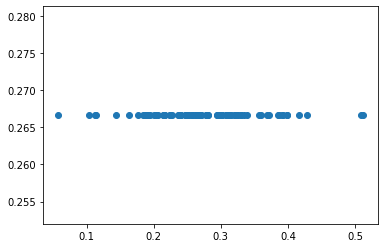

In [55]:
model0 = DummyRegressor()
fit_model(model0, 'dummy')
plt.scatter(y_test, model0.predict(X_test));

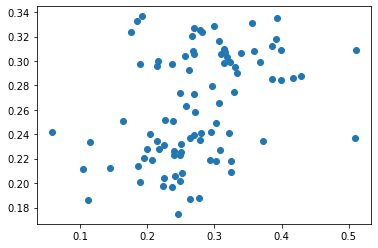

In [53]:
model1 = RandomForestRegressor(n_jobs=-1, random_state=8)
fit_model(model1, 'RFR')
plt.scatter(y_test, model1.predict(X_test));

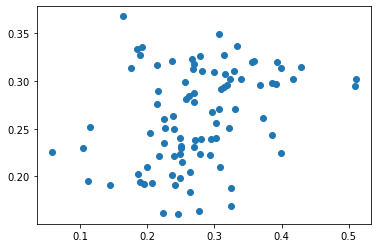

In [56]:
model2 = BaggingRegressor(n_jobs=-1, random_state=8)
fit_model(model2, 'bagging')
plt.scatter(y_test, model2.predict(X_test));

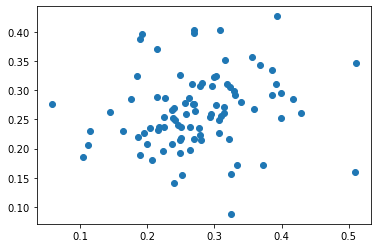

In [57]:
model3 = HistGradientBoostingRegressor(max_iter=10_000, random_state=8)
fit_model(model3, 'GradBoost')
plt.scatter(y_test, model3.predict(X_test));

In [58]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost
score_train,0.000000,0.880999,0.809259,0.998480
score_test,-0.010230,0.090887,-0.028548,-0.385776
rmse,0.080172,0.076054,0.080895,0.093898
mae,0.060118,0.058374,0.062488,0.068800


Looks like in each model we have a very decent train fit but the test fit is horrible, especially with GradBoost (which is the only model that doesn't have bootstrapping... not sure if that's why or not). What confuses me is that the residuals scatter plots make it seem like Boosting is the cleanest fit... 

## Random Forest

[Hyperparameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor) of interest:

* **n_estimators**-- how many trees in forest. Seems simple enough to test a few.
* **max_samples** -- By default, it's all of the X's in the training set. However, I'm curious to see how decreasing this quantity may impact the residuals of y_preds vs y_test.
* **criterion** {“mse”, “mae”}, default=”mse” -- according to the docs, "The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion, and “mae” for the mean absolute error." I think this may be suggesting that if I have issues with model-variance (overfitting), I may want to change the criterion to MAE.
* **max_features** -- this could be an interesting pseudo RFE
* **min_impurity_decrease** -- this may be better than looking at max leave nodes if I care more about how much the model is improve, rather than complexity (which may be driving up model complexity). Otherwise, I may want to look at **max_depth**
* **ccp_alpha** -- This parameter is used to effectively prune out any highly complex models. I don't really know how to use this but I may study this more if model-variance still seems to be an issue.

In [59]:
params_rf = {
    'n_estimators': [10,100,1000],
    'max_samples': [None, 0.66, 0.33],
    'min_impurity_decrease': [0.0, 0.05, 0.1]
}

In [63]:
kf = KFold(n_splits=3, shuffle = True, random_state= 8)

In [60]:
model1a = RandomForestRegressor(criterion='mse')

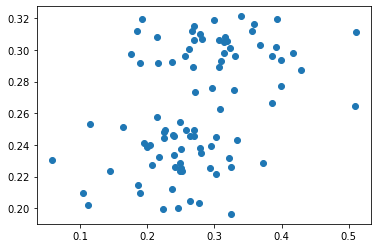

In [71]:
gs1a = GridSearchCV(estimator=model1a, param_grid=params_rf, cv=kf, n_jobs=-1)
fit_model(gs1a, 'GS_RF_MSE')
plt.scatter(y_test, gs1a.predict(X_test));

In [65]:
pd.DataFrame(gs1a.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_min_impurity_decrease,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024330,0.000472,0.004033,4.636245e-05,None,0,10,"{'max_samples': None, 'min_impurity_decrease':...",-0.126718,0.011222,-0.165044,-0.093514,0.075694,27
1,0.238362,0.017492,0.010664,4.097799e-04,None,0,100,"{'max_samples': None, 'min_impurity_decrease':...",-0.098932,0.248627,0.081984,0.077227,0.141930,6
2,2.085595,0.039688,0.084000,2.943788e-03,None,0,1000,"{'max_samples': None, 'min_impurity_decrease':...",-0.093426,0.225962,0.034992,0.055843,0.131221,8
3,0.024665,0.007318,0.003667,4.713142e-04,None,0.05,10,"{'max_samples': None, 'min_impurity_decrease':...",-0.003069,-0.020747,-0.013209,-0.012342,0.007243,10
4,0.156999,0.004900,0.010000,4.899036e-07,None,0.05,100,"{'max_samples': None, 'min_impurity_decrease':...",-0.002852,-0.029152,-0.017122,-0.016375,0.010750,17
5,1.492008,0.019828,0.077667,4.716513e-04,None,0.05,1000,"{'max_samples': None, 'min_impurity_decrease':...",-0.002529,-0.028274,-0.017968,-0.016257,0.010580,16
6,0.022333,0.004714,0.003334,4.706399e-04,None,0.1,10,"{'max_samples': None, 'min_impurity_decrease':...",-0.001431,-0.012987,-0.030458,-0.014958,0.011932,14
7,0.152666,0.001886,0.010000,7.370010e-07,None,0.1,100,"{'max_samples': None, 'min_impurity_decrease':...",-0.001887,-0.023443,-0.010705,-0.012011,0.008848,9
8,1.504343,0.003846,0.077000,2.160421e-03,None,0.1,1000,"{'max_samples': None, 'min_impurity_decrease':...",-0.002603,-0.028601,-0.018792,-0.016665,0.010720,18
9,0.022000,0.000816,0.003667,4.710332e-04,0.66,0,10,"{'max_samples': 0.66, 'min_impurity_decrease':...",-0.005611,0.104653,0.124509,0.074517,0.057236,7


In [66]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE
score_train,0.000000,0.880999,0.809259,0.998480,0.571840
score_test,-0.010230,0.090887,-0.028548,-0.385776,0.136357
rmse,0.080172,0.076054,0.080895,0.093898,0.074127
mae,0.060118,0.058374,0.062488,0.068800,0.056393


In [68]:
model1b = RandomForestRegressor(criterion='mae')

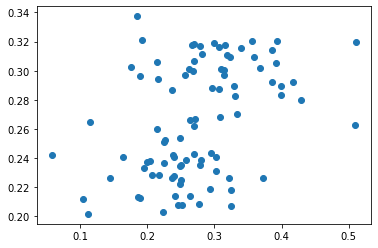

In [72]:
gs1b = GridSearchCV(estimator=model1b, param_grid=params_rf, cv=kf, n_jobs=-1)
fit_model(gs1b, 'GS_RF_MAE')
plt.scatter(y_test, gs1b.predict(X_test));

In [74]:
pd.DataFrame(gs1b.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_min_impurity_decrease,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.065008,0.003554,0.003993,1.113358e-05,None,0,10,"{'max_samples': None, 'min_impurity_decrease':...",-0.213348,0.037401,0.036258,-0.046563,0.117936,27
1,0.665662,0.042499,0.017333,1.037099e-02,None,0,100,"{'max_samples': None, 'min_impurity_decrease':...",-0.172132,0.228532,0.062725,0.039708,0.164378,6
2,5.967332,0.200390,0.078333,2.054540e-03,None,0,1000,"{'max_samples': None, 'min_impurity_decrease':...",-0.160049,0.237320,0.052194,0.043155,0.162351,5
3,0.027998,0.002161,0.004000,8.155614e-04,None,0.05,10,"{'max_samples': None, 'min_impurity_decrease':...",-0.001355,-0.043282,-0.002315,-0.015650,0.019542,11
4,0.248000,0.009416,0.011666,2.356627e-03,None,0.05,100,"{'max_samples': None, 'min_impurity_decrease':...",-0.001173,-0.043215,-0.005091,-0.016493,0.018963,14
5,2.341333,0.058094,0.079666,8.379509e-03,None,0.05,1000,"{'max_samples': None, 'min_impurity_decrease':...",-0.003364,-0.042616,-0.003740,-0.016574,0.018416,16
6,0.026000,0.000816,0.003667,4.714266e-04,None,0.1,10,"{'max_samples': None, 'min_impurity_decrease':...",-0.004192,-0.021806,-0.015544,-0.013847,0.007291,9
7,0.239000,0.014514,0.009333,4.716513e-04,None,0.1,100,"{'max_samples': None, 'min_impurity_decrease':...",-0.004643,-0.043904,-0.003198,-0.017248,0.018858,18
8,2.278666,0.045390,0.077000,1.633264e-03,None,0.1,1000,"{'max_samples': None, 'min_impurity_decrease':...",-0.003394,-0.038156,-0.003808,-0.015119,0.016291,10
9,0.050666,0.001700,0.003001,4.052337e-07,0.66,0,10,"{'max_samples': 0.66, 'min_impurity_decrease':...",-0.163514,0.181442,-0.142957,-0.041676,0.157992,26


In [73]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE
score_train,0.000000,0.880999,0.809259,0.998480,0.573450,0.567534
score_test,-0.010230,0.090887,-0.028548,-0.385776,0.140765,0.136509
rmse,0.080172,0.076054,0.080895,0.093898,0.073938,0.074121
mae,0.060118,0.058374,0.062488,0.068800,0.056469,0.055853


Looks like MSE and MAE is fairly close. Probably means that the MSE isn't being impacted as heavily by the outliers as I feared. So I think I can keep going with MSE as my criteron. Interestingly, in both cases, using a max_samples of 0.33 worked best. I'm thinking this may help with overfitting. Also, more estimators seem to help, not fewer. Playing with the impurity decrease did not help at all. I may do one more grid search looking at some more estimators and switch to max_depth instead of min_impurity_decrease.

In [76]:
params_rf2 = {
    'n_estimators': [1000, 10_000],
    'max_samples': [0.33, 0.15],
    'max_depth': [5, 10, 20, 50]
}

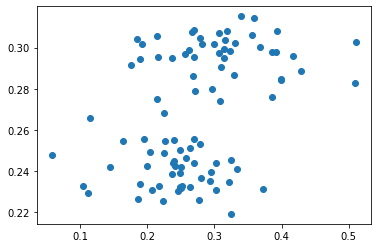

In [80]:
gs1c = GridSearchCV(estimator=model1a, param_grid=params_rf2, cv=kf, n_jobs=-1)
fit_model(gs1c, 'GS_RF_MSE2')
plt.scatter(y_test, gs1c.predict(X_test));

In [81]:
pd.DataFrame(gs1c.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.683064,0.080427,0.079333,0.002868,5,0.33,1000,"{'max_depth': 5, 'max_samples': 0.33, 'n_estim...",0.037540,0.215369,0.106799,0.119903,0.073187,14
1,16.285233,0.174932,0.828305,0.015178,5,0.33,10000,"{'max_depth': 5, 'max_samples': 0.33, 'n_estim...",0.043569,0.219722,0.105707,0.122999,0.072946,12
2,1.664008,0.111968,0.078000,0.001633,5,0.15,1000,"{'max_depth': 5, 'max_samples': 0.15, 'n_estim...",0.090170,0.222548,0.108334,0.140351,0.058593,3
3,15.410473,0.105528,0.828667,0.010078,5,0.15,10000,"{'max_depth': 5, 'max_samples': 0.15, 'n_estim...",0.086952,0.206894,0.129827,0.141224,0.049625,2
4,1.675178,0.014558,0.082334,0.000471,10,0.33,1000,"{'max_depth': 10, 'max_samples': 0.33, 'n_esti...",0.037689,0.227377,0.103355,0.122807,0.078652,13
5,17.335254,0.390880,0.861695,0.015214,10,0.33,10000,"{'max_depth': 10, 'max_samples': 0.33, 'n_esti...",0.040260,0.223026,0.106566,0.123284,0.075544,11
6,1.545644,0.016412,0.083334,0.002625,10,0.15,1000,"{'max_depth': 10, 'max_samples': 0.15, 'n_esti...",0.082864,0.206191,0.137802,0.142285,0.050448,1
7,15.883687,0.113555,0.837038,0.028807,10,0.15,10000,"{'max_depth': 10, 'max_samples': 0.15, 'n_esti...",0.085499,0.207347,0.118217,0.137021,0.051491,5
8,1.675349,0.008742,0.081983,0.002138,20,0.33,1000,"{'max_depth': 20, 'max_samples': 0.33, 'n_esti...",0.028549,0.227731,0.103410,0.119897,0.082147,15
9,17.848842,0.102360,0.882514,0.024128,20,0.33,10000,"{'max_depth': 20, 'max_samples': 0.33, 'n_esti...",0.038868,0.227932,0.103563,0.123454,0.078456,10


In [82]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE,GS_RF_MSE2
score_train,0.000000,0.880999,0.809259,0.998480,0.573450,0.567534,0.389442
score_test,-0.010230,0.090887,-0.028548,-0.385776,0.140765,0.136509,0.148589
rmse,0.080172,0.076054,0.080895,0.093898,0.073938,0.074121,0.073601
mae,0.060118,0.058374,0.062488,0.068800,0.056469,0.055853,0.055006


Hm, so n_estimator truly seems best at 1000, however max_sample did even better at 0.15 which just seem crazy low. Max_depth did best at 10. However, I will say, most of these scores are really close to each other, unlike the previous gridsearch, so I think I'm reaching a capping point. I'm going to run a randomforest with my optimized parameters to see how it does on the full dataset.

In [99]:
model1c = RandomForestRegressor(n_estimators= 1000, max_features=0.33, max_depth=10, random_state=8)
fit_model(model1c, 'rfr_op')

0.11049907720373686

In [97]:
pd.DataFrame(fit_results,index=['score_train', 'score_test', 'rmse', 'mae'])

,dummy,RFR,bagging,GradBoost,GS_RF_MSE,GS_RF_MAE,GS_RF_MSE2,rfr_op
score_train,0.000000,0.880999,0.809259,0.998480,0.573450,0.567534,0.389442,0.863646
score_test,-0.010230,0.090887,-0.028548,-0.385776,0.140765,0.136509,0.148589,0.110499
rmse,0.080172,0.076054,0.080895,0.093898,0.073938,0.074121,0.073601,0.075229
mae,0.060118,0.058374,0.062488,0.068800,0.056469,0.055853,0.055006,0.057204


## Bagging

* **n_estimators**
* **max_samples**
* **max_features

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [109]:
fit_results = {}

def fit_model(model, name):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
    fit_results[name] = (score, rmse)
    return score

In [ ]:
model0 = DummyRegressor()
fit_model(model0, 'dummy')

In [111]:
model1 = LinearRegression(n_jobs=-1)
fit_model(model1, 'plain_linreg')

0.21859654846224486

In [114]:
model2 = RandomForestRegressor(n_jobs=-1, random_state=123)
fit_model(model2, 'RFR')

0.13740517005245223

In [115]:
model3 = HistGradientBoostingRegressor(max_iter=10_000, random_state=123)
fit_model(model3, 'GradBoost')

-0.25126471106226456

In [120]:
model4 = BaggingRegressor(n_jobs=-1, n_estimators=100, random_state=123)
fit_model(model4, 'bagging')

0.15359534479323111

In [121]:
model5 = make_pipeline(StandardScaler(), HistGradientBoostingRegressor(max_iter=10_000, random_state=123))
fit_model(model5, 'GB_w_scaler')

-0.25126471106226456

In [122]:
model6 = make_pipeline(StandardScaler(),Ridge())
fit_model(model6, 'plain_ridge')

0.22099629888522287

In [123]:
model7 = make_pipeline(StandardScaler(),Lasso())
fit_model(model7, 'lasso')

-0.005464464679645564